In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import warnings
import seaborn as sns  # seaborn画出的图更好看，且代码更简单，缺点是可塑性差
import time
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (20, 10)  # 设置输出图片大小
sns.set(color_codes=True)  # seaborn设置背景


df = pd.read_excel('table\表.xlsx', index_col=0)


In [32]:
predict=pd.read_csv('预测结果.csv')
df['预计黄金涨幅']=predict['预计黄金涨幅']
df['预计比特币涨幅']=predict['预计比特币涨幅']
df['比特币残差']=predict['比特币残差']
df['黄金残差']=predict['黄金残差']
df['黄金预测方差'] = predict['黄金预测方差']
df['比特币预测方差'] = predict['比特币预测方差']
df.to_excel('table/result.xlsx')


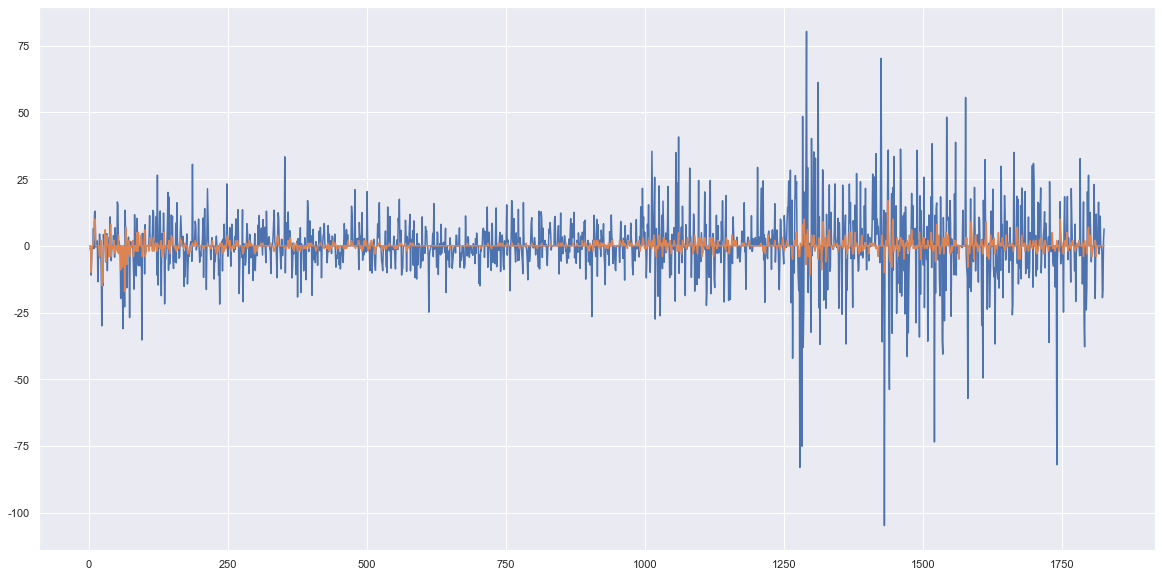

In [33]:
df['USD (PM)'][1:].diff(1).dropna().plot()
df['预计黄金涨幅'][1:].plot()
plt.savefig('img/预计黄金涨幅.png')
plt.show()


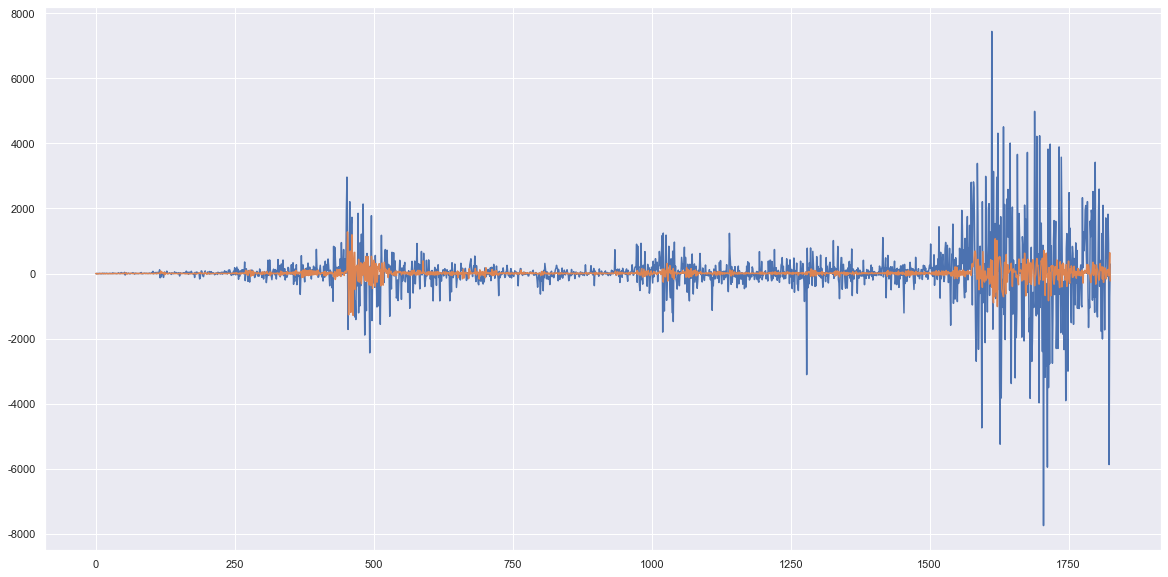

In [34]:
df['Value'].diff(1).dropna().plot()
df['预计比特币涨幅'].plot()
plt.savefig('img/预计比特币涨幅.png')
plt.show()


In [35]:
def zeros(x):
    if x == 0:
        return np.nan
    else:
        return x


In [36]:
df['黄金残差'] = df['黄金残差'].apply(zeros).fillna(method='ffill')
df['预计黄金涨幅'] = df['预计黄金涨幅'].apply(zeros).fillna(method='ffill')
# df=df.fillna()
max_, min_ = df['黄金残差'].max(), df['黄金残差'].min()
df['黄金残差'] = df['黄金残差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['比特币残差'].max(), df['比特币残差'].min()
df['比特币残差'] = df['比特币残差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['预计黄金涨幅'].max(), df['预计黄金涨幅'].min()
df['预计黄金涨幅归一化'] = df['预计黄金涨幅'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['预计比特币涨幅'].max(), df['预计比特币涨幅'].min()
df['预计比特币涨幅归一化'] = df['预计比特币涨幅'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币6日乖离率'].max(), df['比特币6日乖离率'].min()
df['比特币6日乖离率'] = df['比特币6日乖离率'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['黄金12日乖离率'].max(), df['黄金12日乖离率'].min()
df['黄金12日乖离率'] = df['黄金12日乖离率'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币预测方差'].max(), df['比特币预测方差'].min()
df['比特币预测方差'] = df['比特币预测方差'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['黄金预测方差'].max(), df['黄金预测方差'].min()
df['黄金预测方差'] = df['黄金预测方差'].apply(lambda x: (x-min_)/(max_-min_))

df[['预计黄金涨幅归一化', '黄金残差', '黄金12日乖离率']].to_csv('gold_analysis.csv')
df[['预计比特币涨幅归一化', '比特币残差', '比特币6日乖离率']].to_csv('bitcoin_analysis.csv')


In [37]:
df['黄金买入评分'] = 0.17*0.2*df['预计黄金涨幅归一化']+df['黄金牛市']*0.83*0.2-0.74*abs(df['黄金12日乖离率']-0.5)-0.06*df['黄金残差']
df['比特币买入评分'] = 0.17*0.2*df['预计比特币涨幅归一化']+df['比特币牛市'] * \
    0.83*0.2-0.74*abs(df['比特币6日乖离率']-0.5)-0.06*df['比特币残差']


## 归一化

In [38]:
max_, min_ = df['黄金买入评分'].max(), df['黄金买入评分'].min()
df['黄金买入评分'] = df['黄金买入评分'].apply(lambda x: (x-min_)/(max_-min_))

max_, min_ = df['比特币买入评分'].max(), df['比特币买入评分'].min()
df['比特币买入评分'] = df['比特币买入评分'].apply(lambda x: (x-min_)/(max_-min_))


In [39]:
bh =0.9
bl =0.42



In [40]:

gh = 0.8
gl = 0.38

In [41]:
for i in df.index[1:]:
    df['黄金涨幅'][i] = df['USD (PM)'][i]-df['USD (PM)'][i-1]
    df['比特币涨幅'][i] = df['Value'][i]-df['Value'][i-1]


In [42]:
df['总资产'][0] = 1000.0
df['现金持有份额'][0] = 1000.0
df['黄金持有份额'][0] = 0.0
for i in df.columns[1:]:
    df[i] = df[i].astype('float')


In [43]:
# 黄金买0.58，卖0.3,中间不动
# 比特币买0.71，卖56

per_gold = 0.01
per_bt = 0.02

for i in range(1, df.shape[0]):
    bt = df['比特币买入评分'][i]
    df['当前黄金利润'][i] = df['当前黄金利润'][i-1]+df['黄金涨幅'][i-1]*df['黄金持有份额'][i-1]
    df['当前比特币利润'][i] = df['当前比特币利润'][i-1]+df['比特币涨幅'][i-1]*df['比特币持有份额'][i-1]
    df['黄金持有份额'][i] = df['黄金持有份额'][i-1]
    df['现金持有份额'][i] = df['现金持有份额'][i-1]
    df['比特币持有份额'][i] = df['比特币持有份额'][i-1]

    if df['DealDay'][i]:  # 判断交易日
        gold = df['黄金买入评分'][i]
        if gold > gh:
            if bt > bh:  # 两者都可买入时
                if gold-gh > (bt-bh):  #买入黄金
                    df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                        gold*(1-per_gold)/df['USD (PM)'][i-1]
                    df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                else:  # 买入比特币
                    df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
                        df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                    df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
            else:  # 只能买黄金时
                df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                    gold*(1-per_gold)/df['USD (PM)'][i-1]
                df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                 print('只能买黄金',df['黄金持有份额'][i])
        if gold < gl:  #卖出黄金
            df['黄金持有份额'][i] = df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-gl)
            
            df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['黄金持有份额'][i-1] * \
                (1+gold-gl)*(1-per_gold)*df['USD (PM)'][i-1]
#             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
        continue

    if bt > bh:  # 买入比特币
        df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
            df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
        df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
    if bt < bl:  # 卖出比特币
        df['比特币持有份额'][i] = df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+bt-bl)
        df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['比特币持有份额'][i-1] * \
            (1+bt-bl)*(1-per_bt)*df['Value'][i-1]
#         print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])


In [47]:
def fun(per_bt , per_gold):
    df['总资产'][0] = 1000.0
    df['现金持有份额'][0] = 1000.0
    df['黄金持有份额'][0] = 0.0
    for i in range(1, df.shape[0]):
        bt = df['比特币买入评分'][i]
        df['当前黄金利润'][i] = df['当前黄金利润'][i-1] + \
            df['黄金涨幅'][i-1]*df['黄金持有份额'][i-1]
        df['当前比特币利润'][i] = df['当前比特币利润'][i-1] + \
            df['比特币涨幅'][i-1]*df['比特币持有份额'][i-1]
        df['黄金持有份额'][i] = df['黄金持有份额'][i-1]
        df['现金持有份额'][i] = df['现金持有份额'][i-1]
        df['比特币持有份额'][i] = df['比特币持有份额'][i-1]
        if df['DealDay'][i]:  # 判断交易日
            gold = df['黄金买入评分'][i]
            if gold > gh:
                if bt > bh:  # 两者都可买入时
                    if gold-gh > (bt-bh)*2:  # 买入黄金
                        df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                            gold*(1-per_gold)/df['USD (PM)'][i-1]
                        df['现金持有份额'][i] = df['现金持有份额'][i-1] - \
                            df['现金持有份额'][i-1]*gold
    #                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                    else:  # 买入比特币
                        df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
                            df['现金持有份额'][i-1]*bt * \
                                (1-per_bt)/df['Value'][i-1]
                        df['现金持有份额'][i] = df['现金持有份额'][i-1] - \
                            df['现金持有份额'][i-1]*bt
    #                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
                else:  # 只能买黄金时
                    df['黄金持有份额'][i] = df['黄金持有份额'][i-1]+df['现金持有份额'][i-1] * \
                        gold*(1-per_gold)/df['USD (PM)'][i-1]
                    df['现金持有份额'][i] = df['现金持有份额'][i-1] - \
                        df['现金持有份额'][i-1]*gold
    #                 print('只能买黄金',df['黄金持有份额'][i])
            if gold < gl:  # 买入黄金
                df['黄金持有份额'][i] = df['黄金持有份额'][i-1] - \
                    df['黄金持有份额'][i-1]*(1+gold-gl)
                df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['黄金持有份额'][i-1] * \
                    (1+gold-gl)*(1-per_gold)*df['USD (PM)'][i-1]
    #             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
            continue
        if bt > bh:  # 买入比特币
            df['比特币持有份额'][i] = df['比特币持有份额'][i-1] + \
                df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
            df['现金持有份额'][i] = df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
    #         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
        if bt < bl:  # 卖出比特币
            df['比特币持有份额'][i] = df['比特币持有份额'][i-1] - \
                df['比特币持有份额'][i-1]*(1+gold-bl)
            df['现金持有份额'][i] = df['现金持有份额'][i-1]+df['比特币持有份额'][i-1] * \
                (1+gold-bl)*(1-per_gold)*df['Value'][i-1]
    df['总资产']=df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
    
    return df['总资产'][len(df)-1]


In [48]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import math

# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['per_bt', 'per_gold'],
    'bounds': [[0.01,0.10],
               [0.01, 0.10]]
}


def evaluate(X):  # 这里是我们要进行灵敏度分析的模型,接受一个数组,每个数组元素作为模型的一个输入,模型的输出是一个float,干函数返回的时候再讲所有输出并起来
    return np.array([fun(x[0],x[1]) for x in X])


# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = evaluate(param_values)
print(param_values.shape, Y.shape)
# Perform analysis (这里运行完成后会自动对结果进行展示)
Si = sobol.analyze(problem, Y, print_to_console=True)
print()

# Print the first-order sensitivity indices  一阶灵敏度
print('S1:', Si['S1'])

# Print the second-order sensitivity indices   二阶灵敏度
print("x1-x2:", Si['S2'][0, 1])
print("x1-x3:", Si['S2'][0, 2])
print("x2-x3:", Si['S2'][1, 2])

(6000, 2) (6000,)
                ST   ST_conf
per_bt    0.169989  0.016181
per_gold  0.835714  0.059050
                S1  S1_conf
per_bt    0.162632  0.03713
per_gold  0.828448  0.07251
                         S2   S2_conf
(per_bt, per_gold)  0.00875  0.067161

S1: [0.16263186 0.82844833]
x1-x2: 0.008750054164580967


IndexError: index 2 is out of bounds for axis 1 with size 2

In [49]:
Si

{'S1': array([0.16263186, 0.82844833]),
 'S1_conf': array([0.03712982, 0.07250985]),
 'ST': array([0.1699892 , 0.83571382]),
 'ST_conf': array([0.01618128, 0.05905005]),
 'S2': array([[       nan, 0.00875005],
        [       nan,        nan]]),
 'S2_conf': array([[       nan, 0.06716077],
        [       nan,        nan]])}

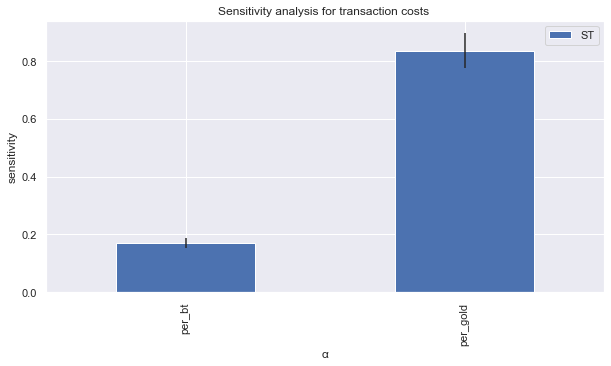

In [54]:
from SALib.plotting.bar import plot as barplot
import matplotlib.pyplot as plot
plt.rcParams['figure.figsize'] = (10, 5)  # 设置输出图片大小
Si_df = Si.to_df()
barplot(Si_df[0])
plt.xlabel('α')
plt.ylabel('sensitivity')
plt.title('Sensitivity analysis for transaction costs')
plt.savefig('img/灵敏度分析.png')
plot.show()
